## Homework - Problem 1

In this notebook, we learned the various components of an LLM. 
    Your homework this week is to take the mini LLM we created from scratch and run your own training loop. Show how the training and validation perplexity change over the steps.
    

Before you begin, make sure that you have your environment set up and your repo refreshed, as described in previous lessons, and reviewed in the accompanying 'Readme.md' file. Make sure that you select the kernel 'datascience/conda-2023-01-10' at the top-left of the Jupyter notebook.

In [1]:
import os
os.environ["HTTP_PROXY"]="http://proxy-01.pub.alcf.anl.gov:3128"
os.environ["HTTPS_PROXY"]="http://proxy-01.pub.alcf.anl.gov:3128"
os.environ["http_proxy"]="http://proxy-01.pub.alcf.anl.gov:3128"
os.environ["https_proxy"]="http://proxy-01.pub.alcf.anl.gov:3128"
os.environ["ftp_proxy"]="http://proxy-01.pub.alcf.anl.gov:3128" 

In [2]:
%matplotlib inline
#os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [3]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

### Set up hyperparameters:

In [4]:
# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 10
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4 ## so head_size = 16
n_layer = 4
dropout = 0.0
# ------------

### Load in data and create train and test datasets

We're going to be using the tiny Shakespeare dataset. 
Data is tokenized according to a simple character based tokenizer.
Data is split into a train and test set so we have something to test after performing training (9:1 split).

In [5]:
with open('dataset/input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

### Set up the components of the Decoder block: 
* MultiHeadAttention
* FeedForward Network

In [6]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C) 16,32,16
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd), # Projection layer going back into the residual pathway
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)


### Combine components into the Decoder block

In [7]:
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))    # Communication
        x = x + self.ffwd(self.ln2(x))  # Computation
        return x

### Set up the full Transformer model 
This is a combination of the Token embeddings, Positional embeddings, a stack of Transformer blocks and an output block.

In [8]:
# super simple language model
class LanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx



In [9]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

## References

Here are some recommendations for further reading and additional code for review.

* "The Illustrated Transformer" by Jay Alammar
* "Visualizing A Neural Machine Translation Model (Mechanics of Seq2seq Models With Attention)"
* "The Illustrated GPT-2 (Visualizing Transformer Language Models)"
* "A gentle introduction to positional encoding"
* "LLM Tutorial Workshop (Argonne National Laboratory)"
* "LLM Tutorial Workshop Part 2 (Argonne National Laboratory)"

This loop trains the LanguageModel using batches of data obtained from the get_batch function. It calculates the loss, backpropagates it, and updates the model's parameters using the AdamW optimizer. It also evaluates the model on both training and validation sets periodically and saves the model with the lowest validation loss. Finally, it loads the best model for inference.

In [26]:
%%time
model = LanguageModel().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

best_val_loss = float('inf')  # Initialize best_val_loss with positive infinity

train_perplexities = []
val_perplexities = []

for iteration in range(max_iters):
    model.train()
    optimizer.zero_grad()
    X, Y = get_batch('train')
    logits, loss = model(X, Y)
    loss.backward()
    optimizer.step()

    if iteration % eval_interval == 0:
        train_loss, val_loss = estimate_loss()['train'], estimate_loss()['val']
        train_perplexity = torch.exp(train_loss)
        val_perplexity = torch.exp(val_loss)
        
        train_perplexities.append(train_perplexity)
        val_perplexities.append(val_perplexity)
        
        print(f"Iteration {iteration}: Train Loss: {train_loss}, Validation Loss: {val_loss}")
        #print(f"Iteration {iteration}: Train Perplexity: {train_perplexity}, Validation Perplexity: {val_perplexity}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            print("Best model saved!")

# Load the best model for inference
model.load_state_dict(torch.load('best_model.pth'))
model.eval()            

Iteration 0: Train Loss: 4.198572635650635, Validation Loss: 4.199017524719238
Best model saved!
Iteration 10: Train Loss: 3.4328620433807373, Validation Loss: 3.447328567504883
Best model saved!
Iteration 20: Train Loss: 3.2509169578552246, Validation Loss: 3.2914047241210938
Best model saved!
Iteration 30: Train Loss: 3.155733585357666, Validation Loss: 3.1668624877929688
Best model saved!
Iteration 40: Train Loss: 3.0352659225463867, Validation Loss: 3.055264949798584
Best model saved!
Iteration 50: Train Loss: 2.9171783924102783, Validation Loss: 2.946181297302246
Best model saved!
Iteration 60: Train Loss: 2.845949172973633, Validation Loss: 2.8629419803619385
Best model saved!
Iteration 70: Train Loss: 2.770085096359253, Validation Loss: 2.7775886058807373
Best model saved!
Iteration 80: Train Loss: 2.724331855773926, Validation Loss: 2.7282931804656982
Best model saved!
Iteration 90: Train Loss: 2.6740050315856934, Validation Loss: 2.6940741539001465
Best model saved!
Iteration 

LanguageModel(
  (token_embedding_table): Embedding(65, 64)
  (position_embedding_table): Embedding(32, 64)
  (blocks): Sequential(
    (0): Block(
      (sa): MultiHeadAttention(
        (heads): ModuleList(
          (0): Head(
            (key): Linear(in_features=64, out_features=16, bias=False)
            (query): Linear(in_features=64, out_features=16, bias=False)
            (value): Linear(in_features=64, out_features=16, bias=False)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (1): Head(
            (key): Linear(in_features=64, out_features=16, bias=False)
            (query): Linear(in_features=64, out_features=16, bias=False)
            (value): Linear(in_features=64, out_features=16, bias=False)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (2): Head(
            (key): Linear(in_features=64, out_features=16, bias=False)
            (query): Linear(in_features=64, out_features=16, bias=False)
            (value):

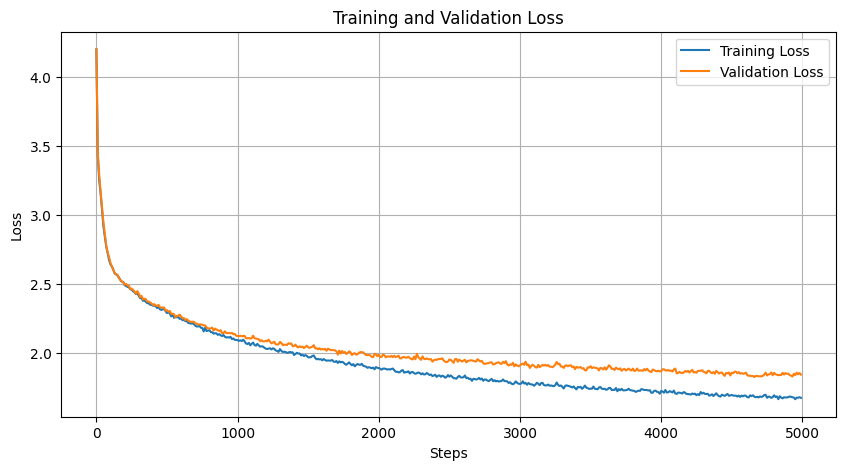

In [27]:
import matplotlib.pyplot as plt
import numpy as np
# Plotting the loss function
plt.figure(figsize=(10, 5))
plt.plot(range(0, max_iters, eval_interval), np.log(train_perplexities), label='Training Loss')
plt.plot(range(0, max_iters, eval_interval), np.log(val_perplexities), label='Validation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [40]:
# Set the model to evaluation mode
#model.eval()

# Encode the input text
input_text = "Where is the dog?"
input_indices = torch.tensor(encode(input_text), dtype=torch.long).unsqueeze(0).to(device)

# Generate text using the model
max_new_tokens = 100  # Maximum number of tokens to generate
generated_indices = model.generate(input_indices, max_new_tokens)

# Decode the generated indices to text
generated_text = decode(generated_indices.squeeze().cpu().numpy())

# Print the generated text
print("Generated Text:")
print(generated_text)


Generated Text:
Where is the dog?
Crist RICHESMARET:
Had let nown a the periant om This been made,
Angelfics yee at what wall lark en


## Homework - Problem 2
Run the same training loop but modify one of the hyperparameters from this list: 

hyperparameters:

n_embd = 64

n_head = 4 ## so head_size = 16

n_layer = 4

Run this at least 4 times with a different value and plot each perplexity over training step. Write a sentence on how the perplexity changed.

In [10]:
# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 10
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
### n_head = 4 ## so head_size = 16
n_layer = 4
dropout = 0.0
# ------------

In [18]:
# Varying hyper-parameter values
n_head_values = [1, 2, 4, 8]


In [11]:
%%time

import pickle

# Dictionary to store perplexities for each value of n_head
perplexities = {n_head: {'train': [], 'val': []} for n_head in n_head_values}

for n_head in n_head_values:
    torch.manual_seed(1337)
    print(f"Training with n_head = {n_head}")
    
    # Set n_head
    model = LanguageModel().to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    best_val_loss = float('inf')  # Initialize best_val_loss with positive infinity

    train_perplexities = []
    val_perplexities = []

    for iteration in range(max_iters):
        model.train()
        optimizer.zero_grad()
        X, Y = get_batch('train')
        logits, loss = model(X, Y)
        loss.backward()
        optimizer.step()

        if iteration % eval_interval == 0:
            train_loss, val_loss = estimate_loss()['train'], estimate_loss()['val']
            train_perplexity = torch.exp(train_loss)
            val_perplexity = torch.exp(val_loss)

            train_perplexities.append(train_perplexity)
            val_perplexities.append(val_perplexity)

            print(f"Iteration {iteration}: Train Perplexity: {train_perplexity}, Validation Perplexity: {val_perplexity}")

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), f'best_model_n_head_{n_head}.pth')
                print("Best model saved!")

    # Load the best model for inference
    model.load_state_dict(torch.load(f'best_model_n_head_{n_head}.pth'))
    model.eval()
    
    # Save perplexities
    perplexities[n_head]['train'] = train_perplexities
    perplexities[n_head]['val'] = val_perplexities
    
    # After the training loop ends, save train_perplexities and val_perplexities to disk
    with open(f'train_perplexities{n_head}.pkl', 'wb') as f:
        pickle.dump(train_perplexities, f)        
    with open(f'val_perplexities{n_head}.pkl', 'wb') as f:
        pickle.dump(val_perplexities, f)    

Training with n_head = 1
Iteration 0: Train Perplexity: 64.75614166259766, Validation Perplexity: 64.90975952148438
Best model saved!
Iteration 10: Train Perplexity: 30.904203414916992, Validation Perplexity: 31.362194061279297
Best model saved!
Iteration 20: Train Perplexity: 25.825313568115234, Validation Perplexity: 26.892135620117188
Best model saved!
Iteration 30: Train Perplexity: 23.343217849731445, Validation Perplexity: 23.60135841369629
Best model saved!
Iteration 40: Train Perplexity: 20.60677146911621, Validation Perplexity: 21.011505126953125
Best model saved!
Iteration 50: Train Perplexity: 18.259687423706055, Validation Perplexity: 18.832408905029297
Best model saved!
Iteration 60: Train Perplexity: 17.032800674438477, Validation Perplexity: 17.292278289794922
Best model saved!
Iteration 70: Train Perplexity: 15.803014755249023, Validation Perplexity: 15.904385566711426
Best model saved!
Iteration 80: Train Perplexity: 15.043834686279297, Validation Perplexity: 15.070371

In [19]:
import pickle

# Dictionary to store perplexities for each value of n_head
perplexities = {n_head: {'train': [], 'val': []} for n_head in n_head_values}
#value = {'train':[],'val':[]}
#perplexities = dict.fromkeys(n_head_values, value)

# Load train_perplexities and val_perplexities from disk
for n_head in n_head_values:
    with open(f'train_perplexities{n_head}.pkl', 'rb') as f:
        perplexities[n_head]['train'] = pickle.load(f)    
    with open(f'val_perplexities{n_head}.pkl', 'rb') as f:
        perplexities[n_head]['val'] = pickle.load(f)

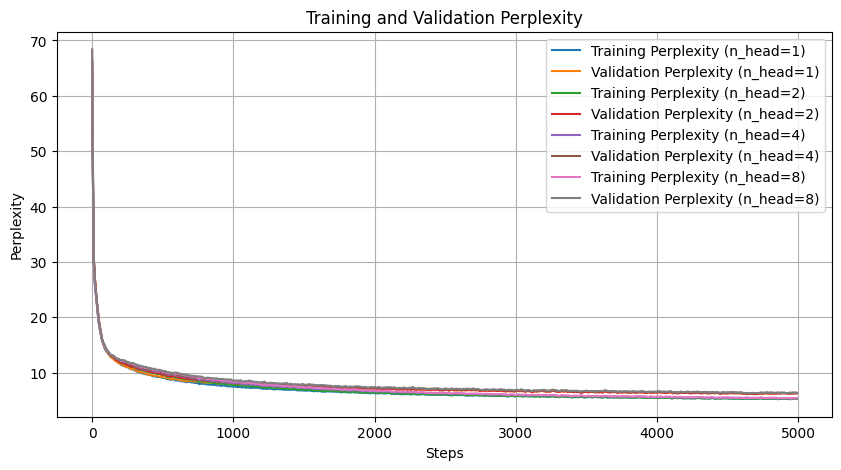

In [20]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 5))
for n_head, perplexity_data in perplexities.items():
    plt.plot(range(0, max_iters, eval_interval), perplexity_data['train'], label=f'Training Perplexity (n_head={n_head})')
    plt.plot(range(0, max_iters, eval_interval), perplexity_data['val'], label=f'Validation Perplexity (n_head={n_head})')

plt.xlabel('Steps')
plt.ylabel('Perplexity')
plt.title('Training and Validation Perplexity')
plt.legend()
plt.grid(True)
plt.show()


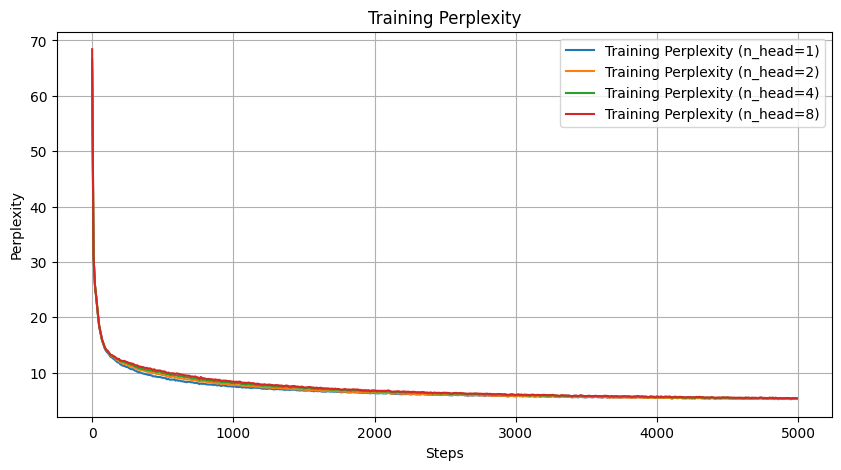

In [21]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 5))
for n_head, perplexity_data in perplexities.items():
    plt.plot(range(0, max_iters, eval_interval), perplexity_data['train'], label=f'Training Perplexity (n_head={n_head})')
    #plt.plot(range(0, max_iters, eval_interval), perplexity_data['val'], label=f'Validation Perplexity (n_head={n_head})')

plt.xlabel('Steps')
plt.ylabel('Perplexity')
plt.title('Training Perplexity')
plt.legend()
plt.grid(True)
plt.show()


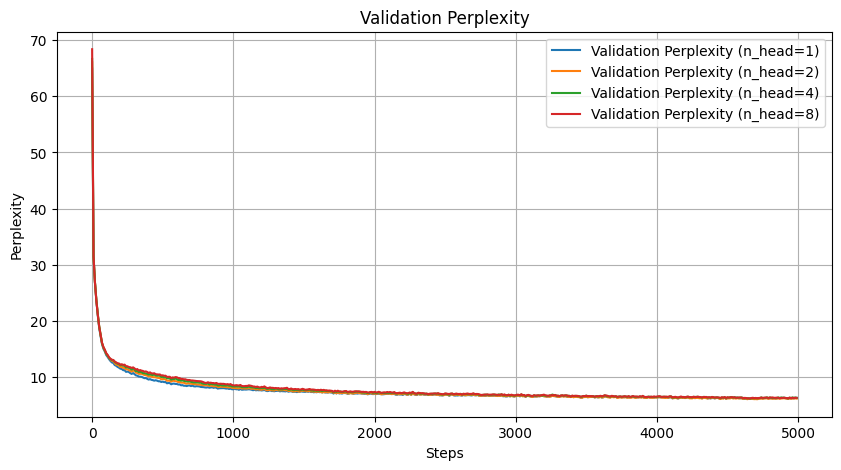

In [22]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 5))
for n_head, perplexity_data in perplexities.items():
    #plt.plot(range(0, max_iters, eval_interval), perplexity_data['train'], label=f'Training Perplexity (n_head={n_head})')
    plt.plot(range(0, max_iters, eval_interval), perplexity_data['val'], label=f'Validation Perplexity (n_head={n_head})')

plt.xlabel('Steps')
plt.ylabel('Perplexity')
plt.title('Validation Perplexity')
plt.legend()
plt.grid(True)
plt.show()


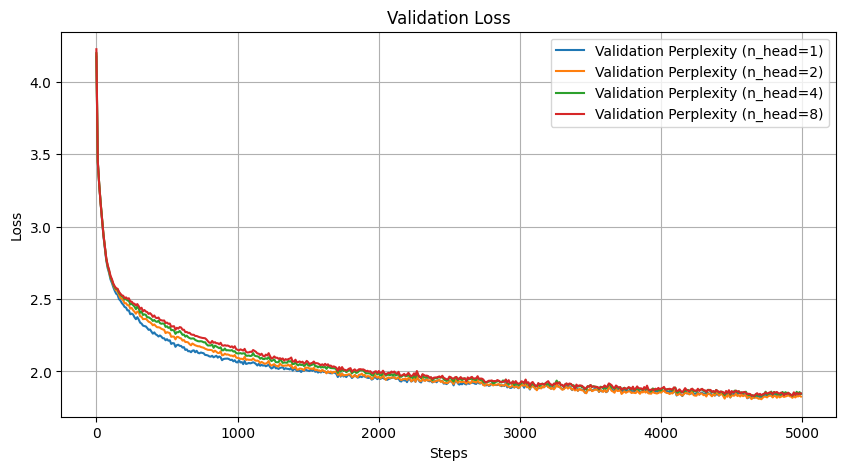

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Plotting
plt.figure(figsize=(10, 5))
for n_head, perplexity_data in perplexities.items():
    #plt.plot(range(0, max_iters, eval_interval), perplexity_data['train'], label=f'Training Perplexity (n_head={n_head})')
    plt.plot(range(0, max_iters, eval_interval), np.log(perplexity_data['val']), label=f'Validation Perplexity (n_head={n_head})')

plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


## Homework - Bonus 1
Bonus 1: output some generated text from each model you trained. Did the output make more sense with some hyperparameters than others? 

In [23]:
input_text = "The dog is sad"

for n_head in n_head_values:
    print(f"Generating text with n_head = {n_head}")
    
    # Load the model
    model = LanguageModel().to(device)
    model.load_state_dict(torch.load(f'best_model_n_head_{n_head}.pth'))
    model.eval()
    
    # Encode the input text
    input_indices = torch.tensor(encode(input_text), dtype=torch.long).unsqueeze(0).to(device)

    # Generate text using the model
    max_new_tokens = 100  # Maximum number of tokens to generate
    generated_indices = model.generate(input_indices, max_new_tokens)

    # Decode the generated indices to text
    generated_text = decode(generated_indices.squeeze().cpu().numpy())

    print("Generated Text:")
    print(generated_text)
    print("\n")
    

Generating text with n_head = 1
Generated Text:
The dog is sadatter woe heaven good fure and longht.

DUCHIO:
Is aming no
the prove Gime you.
Ahony conthangs hust


Generating text with n_head = 2
Generated Text:
The dog is sadome, that have not the that be crince you'lk'd
Hoth you mighh woe? I rad bre's string wearful man pl


Generating text with n_head = 4
Generated Text:
The dog is sadsh'd disservemer, for for grepime,
And this known: I neepose and be king and their world cause:
Outh


Generating text with n_head = 8
Generated Text:
The dog is sady are willifuly vills.

KING EDWARD IV:
Why, let him rightioU'd ahler of By
Feepent a lormal'd these




# Conclusion

Problem 1: The training loop has been added to the code. The training and validation perplexity have been plotted over the steps.

Problem 2: A loop has been added to train the model with different values of the parameter "n_head": 1, 2, 4, and 8. Each perplexity has been plotted over training step. 
At small number of steps (from 100 to 1000), the perplexity increases with the number of heads increasing. At large number of steps, the effect of the number of heads becomes very small.

Bonus 1: The output text has been generated from each model for the same input text. No significant difference in model quality has been found.